# Homework - NSGA-II

Karol Cyganik 148250 \
Sebastian Chwilczyński 148248

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Solution class
class Solution:
    def __init__(self, x, f, name):
        self.x = x  # decision variables
        self.f = f  # evaluation vector [f1, f2]
        self.front = 0  # additional variable storing id of non-dominated front
        self.cd = 0.0  # additional variable storing value of crowding distance
        self.name = name  # additional variable storing name of the solution

    def __str__(self):
        return "[" + self.name + " : F = " + str(self.f) + "]"

In [3]:
# TODO you need to fill a method for evaluation of solution basing on decision variable

def evaluate(x):
    l = 1 + abs(x[1]-0.5) + x[2] + x[3] + x[4]
    f1 = x[0]**10 * l
    f2 = l*(1 - x[0]**10)
    return [0.2*f1+0.8*f2, 0.8*f1+0.2*f2]

In [4]:
# Method for initial population construction for the given size N

def constructInitialPopulation(N):
    P = []
    for i in range(N):
        x = [j for j in range(5)]
        x[0] = np.random.rand()
        x[1] = np.random.rand()
        for j in range(2, 5):
            x[j] = np.random.randint(0, 2)
        f = evaluate(x)
        P.append(Solution(x, f, str(0)+"-"+str(i)))  # adding solution to list
        # which name consists of two parts: generation number
        # in which the solution was created and the number of solution in the population
    return P


P = constructInitialPopulation(10000)
for s in P[:10]:
    print(s)  # Print exemplary solutions (just for tests)

[0-0 : F = [1.9047503986821115, 0.47672096907770545]]
[0-1 : F = [3.476838425598782, 0.869491686467706]]
[0-2 : F = [1.7177666143628945, 0.4872208501396781]]
[0-3 : F = [1.7510803687635308, 0.4382877916591764]]
[0-4 : F = [1.9528687328889442, 0.4882415130279648]]
[0-5 : F = [2.5493118905976195, 0.6630392701604686]]
[0-6 : F = [1.2486176823193504, 0.8969931435656529]]
[0-7 : F = [1.8458715523813594, 0.46229628137294204]]
[0-8 : F = [2.457426450588719, 0.6143566132541074]]
[0-9 : F = [1.0667336889360828, 0.2689699865430243]]


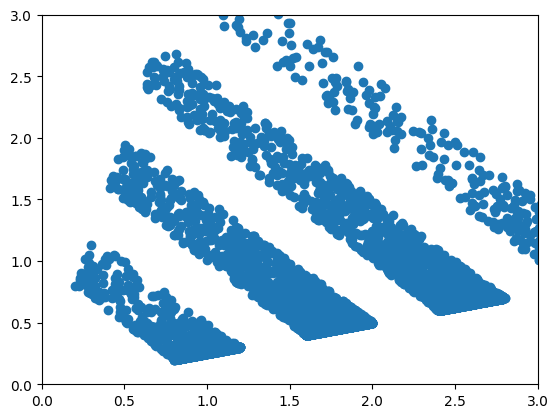

In [5]:
# Below function draws solutions in P
# In big size of N we can see how randomly generated solutions appear
# Please check it e.g. for N=10000.
# TODO Justify the distribution referring to the definition of the problem.

# First we can clearly see that when one function grows the other decreases. This is due to this x[0]**10 and 1-x[0]**10
# Concerning l abs(x[1]-0.5) this just seems like a noise term
# We have these 3 steps because we have 3 binary variables. Additionally l can't be smaller than 1 so we can't reach
# due to this x[0]**10 and 1-x[0]**10 also minima and maxima of the functions are 0.2 and 0.8 for the first step

def plotPopul(P, ax = None):
    if ax is None:
        ax = plt.gca()

    X = [s.f[0] for s in P]
    Y = [s.f[1] for s in P]
    ax.plot(X, Y, ls='', marker='o')
    ax.set_xlim(0, 3.0)
    ax.set_ylim(0, 3.0)


plotPopul(P)

In [6]:
# TODO below function should return list of pairs of solution indices chosen for reproduction.
# From each pair there will be created one descendant individual.
# Selection should be made on the basis on tournament (size 2)
# Output: list of pairs -> [ [idx11, idx12],...,[idxN1, idxN2] ]

def constructParents(N, P):
    solution = []
    for _ in range(N):
        parents = []
        for __ in range(2):
            candidates = np.random.choice(len(P), 2, replace=False)
            best_candidate = sorted(candidates, key=lambda x: P[x].front)[0]
            parents.append(best_candidate)
        solution.append(parents)
    return solution


print(constructParents(10, P))  # TEST

[[3664, 7840], [8081, 8327], [6140, 5673], [9260, 9776], [9414, 313], [8854, 2392], [8795, 7195], [3649, 4899], [4147, 2857], [3589, 2494]]


In [7]:
# TODO below function should make a crossover of two input vectors
# There can be any type of crossover implemented.

def getCrossed(xA, xB):
    crossPoint = np.random.randint(1, len(xA))
    return xA[:crossPoint] + xB[crossPoint:]


print(getCrossed([0.0, 0.5, 1.0], [1.0, 0.25, 0.75]))  # TEST

[0.0, 0.25, 0.75]


In [8]:
# TODO the below function should mutate the input vector x.
# You need to take into account the probability of mutation for each decision variable.
# In case of binary variables, the mutation should be made as a complement to 1:
# new x[i] = 1 - x[i]
# In case of continuous variables, you can use gaussian mutation
# You need to have a protection from potential exceeding values out of  [0, 1] interval.


def mutate(x, prob, std):
    for i in range(2):
        if np.random.rand() < prob:
            x[i] = np.clip(np.random.normal(x[i], std), 0, 1)
    for i in range(2, 4):
         if np.random.rand() < prob:
               x[i] = 1 - x[i]

for std in [0.0, 0.1, 0.2]:  # TEST
    x = [0.0, 0.2, 1.0, 0.0, 0.0]
    mutate(x, 1.0, std)
    print(x)

[0.0, 0.2, 0.0, 1.0, 0.0]
[0.2180365031041784, 0.4391578093252593, 0.0, 1.0, 0.0]
[0.0, 0.34651285684357547, 0.0, 1.0, 0.0]


In [9]:
# Please read the below method
# It generates the vector of descendant solutions basing on selected parents
# and chosen reproduction operators.

def constructOffspring(P, parents, gen, std):
    O = []
    prob = 1.0 / 5.0
    for i in range(len(parents)):
        xO = getCrossed(P[parents[i][0]].x, P[parents[i][1]].x)
        mutate(xO, prob, std)
        O.append(Solution(xO, evaluate(xO), str(gen) + "-" + str(i)))
    return O

In [10]:
# Method for checking the existence of dominance relation
def dominates(sj, sk):
    if sj.f[0] < sk.f[0] and sj.f[1] <= sk.f[1]:
        return True
    if sj.f[0] <= sk.f[0] and sj.f[1] < sk.f[1]:
        return True
    return False

In [11]:
### TODO Below method should do the assignemnt of solutions to non-dominated fronts
### The output should be list of list of indices of solutions in P, assigned to proper fronts.
### E.g. the output  [[3,4,0],[1,5],[2]] means that the solutions with ids 0, 3 and 4 are in a first front,
### 1 and 5 in second front and 2 in the last one. 

def get_front(P,S):
    if len(S) == 1:
        return S
    i = len(S)//2
    T = get_front(P, S[:i])
    B = get_front(P, S[i:])
    N = []
    for b in B:
        is_dominated = False
        for t in T:
            if dominates(P[t], P[b]):
                is_dominated = True
                break
        if not is_dominated:
            N.append(b)

    
    return T+N

def getNonDominatedFronts(P):
    P_sort = sorted(range(len(P)), key = lambda x: P[x].f[0])
    fronts = []
    while len(P_sort) > 0:
        cur_front = get_front(P, P_sort)
        fronts.append(cur_front)
        P_sort = [ps for ps in P_sort if ps not in cur_front]
    return fronts
        

In [12]:
# TODO below method should calculate values of crowding distance (CD) for solutions in P.
# ATTENTION: CD is calculated for each non-dominated front separately;
# Method should return the vector of calculated CD

def getCrowdingDistances(F, P):
    distances = [0.0 for _ in P]
    num_of_f = len(P[0].f)
    MAX_DISTANCE = num_of_f + 0.1 # using infinity with this implementation doesn't make much sense. num_of_f + eps is more than max
    #As with weight 0.5 boundary solutions with all fronts are favored more
    for front in F:
        if len(front) < 3: # if we have 2 variables one is better in f1 and other in f2 so both are boundary
            for solution in front:
                distances[solution] = MAX_DISTANCE 
            continue
        
        to_be_ignored = set()

        for f_id in range(num_of_f):
            #Probably we should have a switch of the sorting between min and max
            sorted_front = sorted(front, key=lambda solution_id: P[solution_id].f[f_id])
            
            min_value = P[sorted_front[0]].f[f_id]
            max_value = P[sorted_front[-1]].f[f_id]
            
            to_be_ignored.add(sorted_front[0])
            distances[sorted_front[0]] = MAX_DISTANCE

            for i in range(1, len(front) - 1): # we can skip last at it will be best in some other f value
                if max_value == min_value or sorted_front[i] in to_be_ignored:
                    continue
                
                upper_value = P[sorted_front[i + 1]].f[f_id]
                lower_value = P[sorted_front[i - 1]].f[f_id]
                distances[sorted_front[i]] += (upper_value - lower_value) / (max_value - min_value)

    return distances

In [13]:
# Below method assigns to solutions their numbers of non-dominated fronts and crowding
# distances values then sort solutions in the population basing on these metrics.
# In case useCD = False, crowding distances is not taken into account while sorting.
# Testing the method for useCD = True and False let us see the gain
# coming from the usage of crowding distances.

def applyScoresAndSort(P, useCD=True):
    F = getNonDominatedFronts(P)
    CD = [0 for _ in P]
    if useCD:
        CD = getCrowdingDistances(F, P)
        mi, ma = min(CD), max(CD)  # crowding distances normalization
        if abs(ma - mi) < 0.00001:
            CD = [0.5 for _ in range(len(P))]
        else:
            CD = [(v-mi)/(ma-mi) for v in CD]

    for s, f in enumerate(F):
        for i in f:
            P[i].front = s
            P[i].cd = CD[i]

    P.sort(key=lambda x: x.front - x.cd * 0.5)  # During the lectures we were told to use CD just within the fronts. Here it looks like too powerful tool as
    #due to this infinity we always keep boundary solutions for every fron.

In [14]:
# TODO Below method should calculate additional statistics which may help
# justify the usage of crowding distances in calculations.
# The method should return average, max and min crowding distances value
# for the solutions and std dev in population P.
# While calculations, omit the boundary values (inf).
# How can we interpret these measures?

# These are just statistics of the distribution of CD distance and may help us in comparing behaviour of algorithms. 
#However as we can see in a moment these creates unintuitive results at first due to outliers created when we don't use CD.

def getStatsCD(P):
    fronts = getNonDominatedFronts(P)
    CD = getCrowdingDistances(fronts, P)
    MAX_DISTANCE = max(CD)
    CD_inf = [v for v in CD if v == MAX_DISTANCE]
    CD = [v for v in CD if v != MAX_DISTANCE]
    if len(CD) == 0:
        return 0, 0, 0, 0, len(CD_inf)
    return np.mean(CD), np.max(CD), np.min(CD), np.std(CD), len(CD_inf)

These two cells below show how NSGA-II algoritm works, illustrate created solutions  in 5 different stages of algorithm and finally write stats for CD. In the first cell CD is not used  while sorting and in the second it is used. You need to read the code and test it for different values of parameters (e.g. population size).
For which variant the algorithm works best?

`Plotting these CD stats just at the end doesn't make that much sense for such an easy problem. We can see more if we see dependensies of these CD as said in additional task`

**Additional task:** evolutionary algorithms are random. That is why running them one time may not be credible. To get more credible result, the algorithm may be run e.g. 20 times and the statistics averaged. Additionally, you can calculate them for each generation and plot their convergence. Moreover, you can plot this for both varinats of algorithm (with and without CD).

However, the stats for CD may not be the best way for scoring the algorithm. You can see that the solutions are highly scattered at the beginning and their CD values are high which is not compatible with the assumption that the higher value, of CD, the better. For better algorithm evaluation, you can use metrics which estimate the distance to Pareto front. You can propose such a method and use it to show the closeness of population to this front. Then when you get this metic and metrics for scoring the dispersion of solutions, you can better compare algorithms.

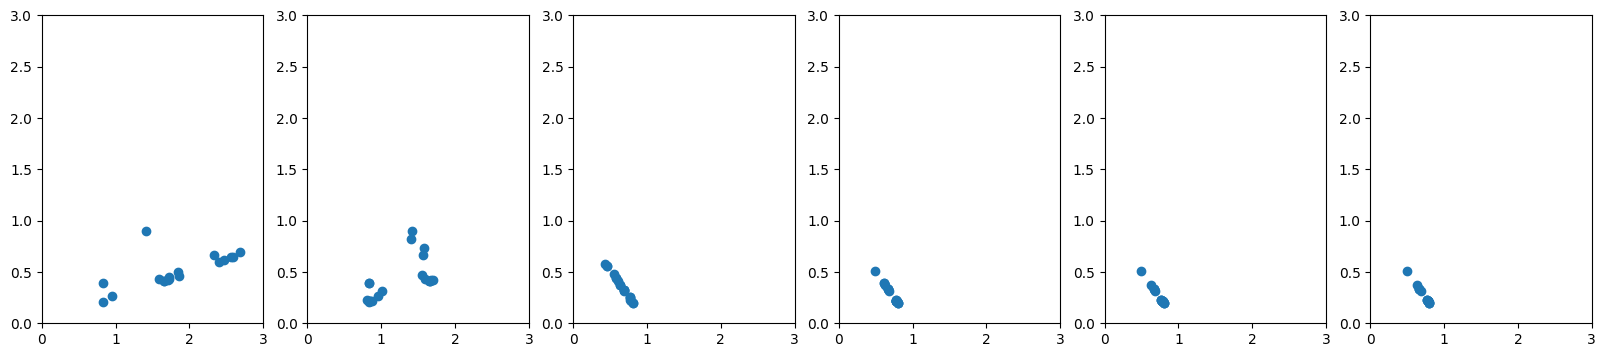

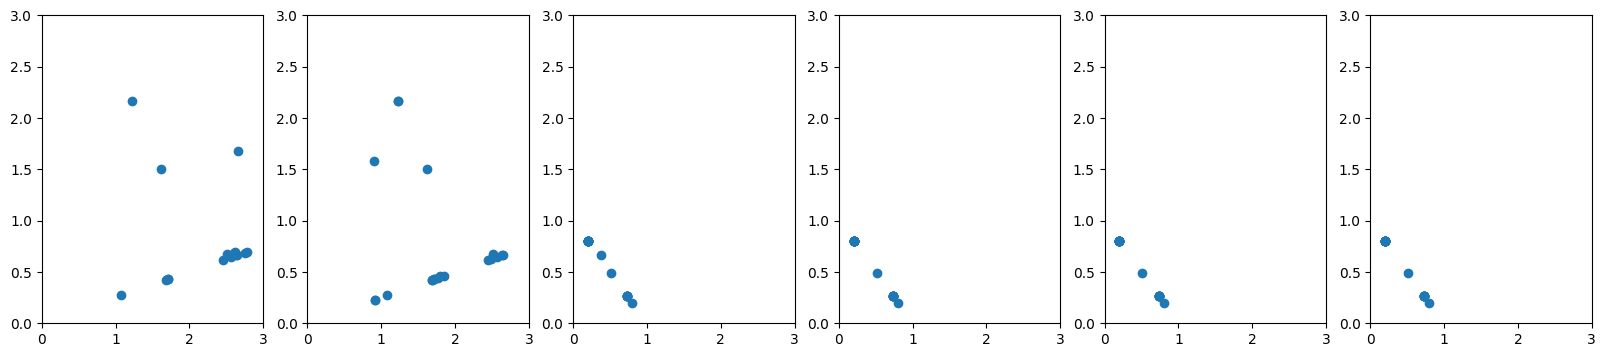

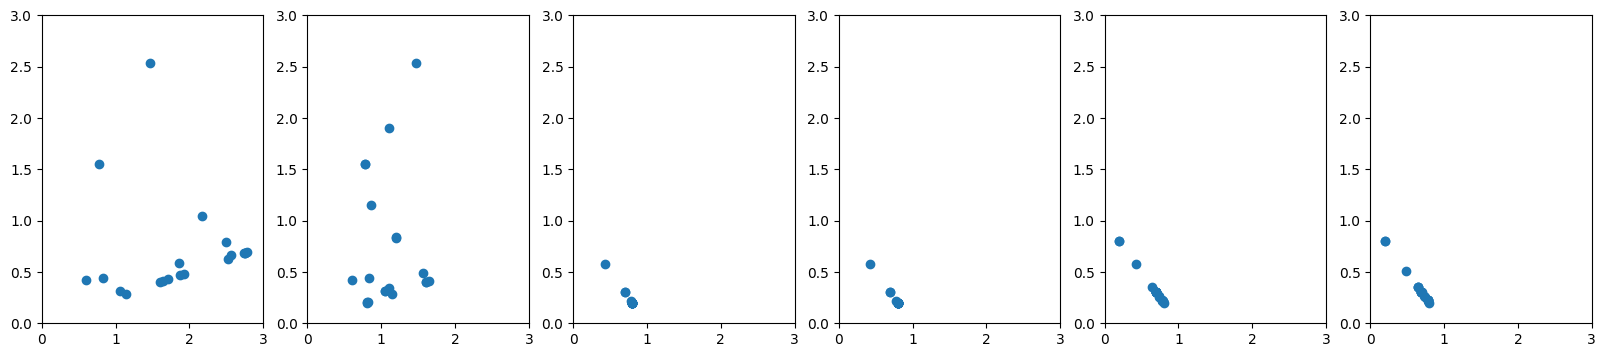

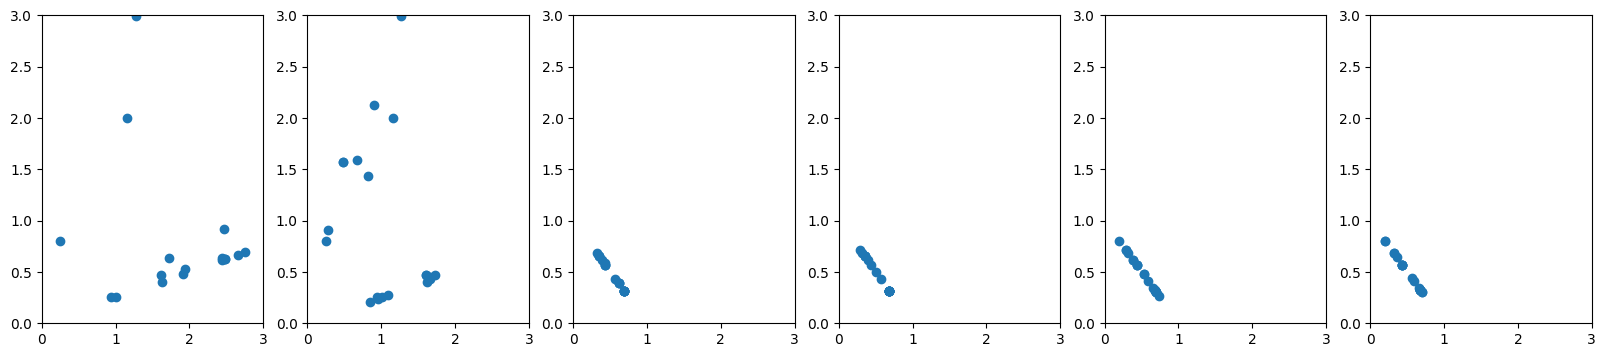

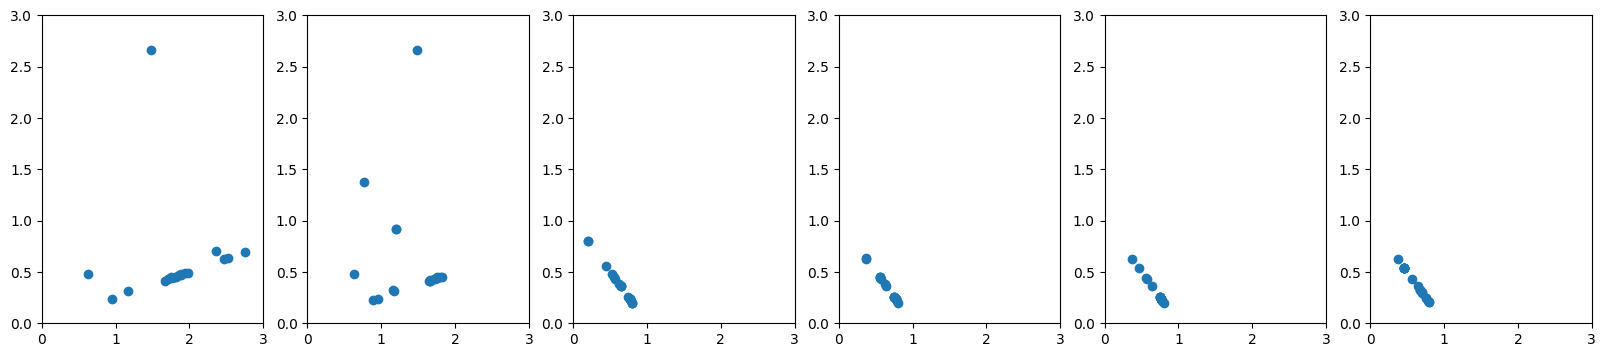

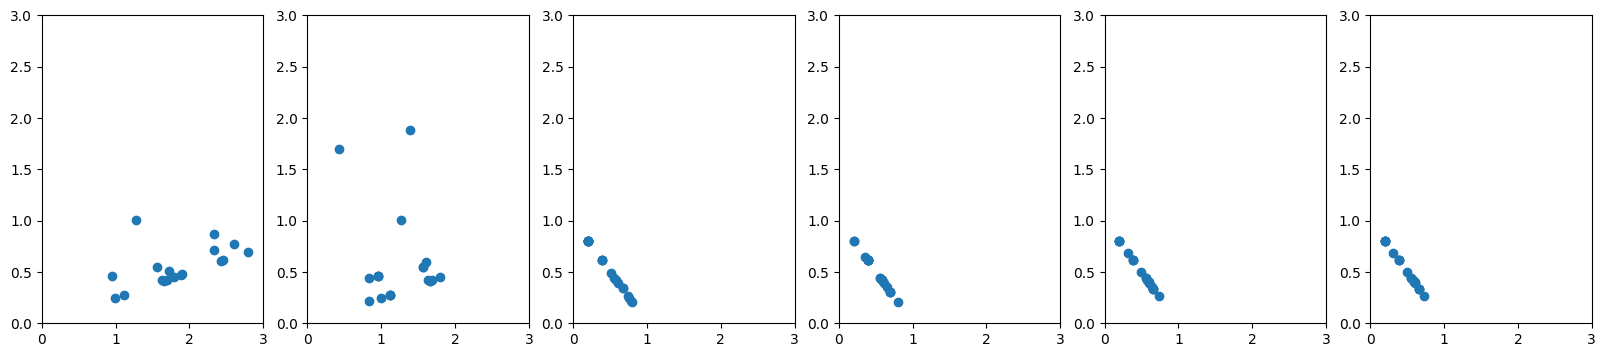

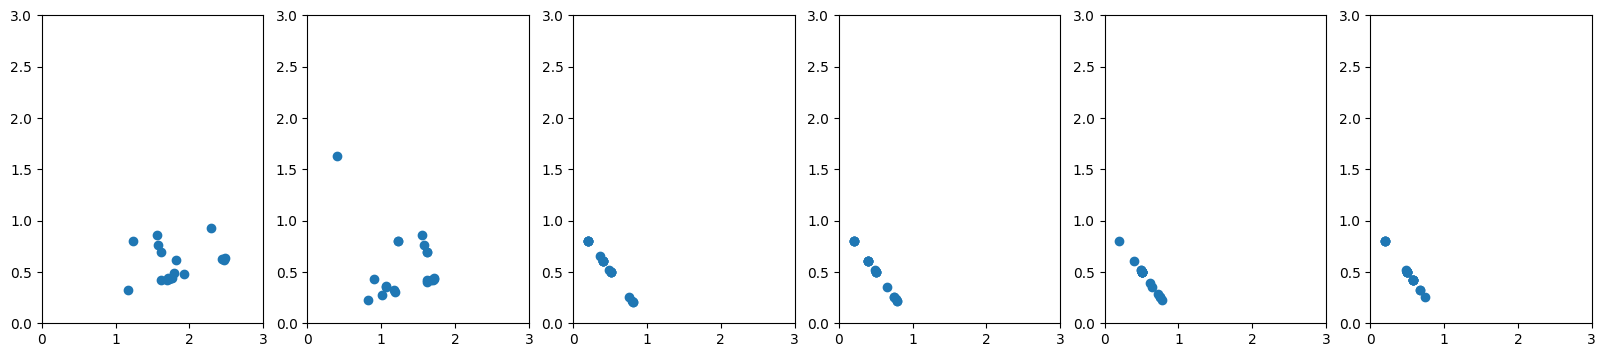

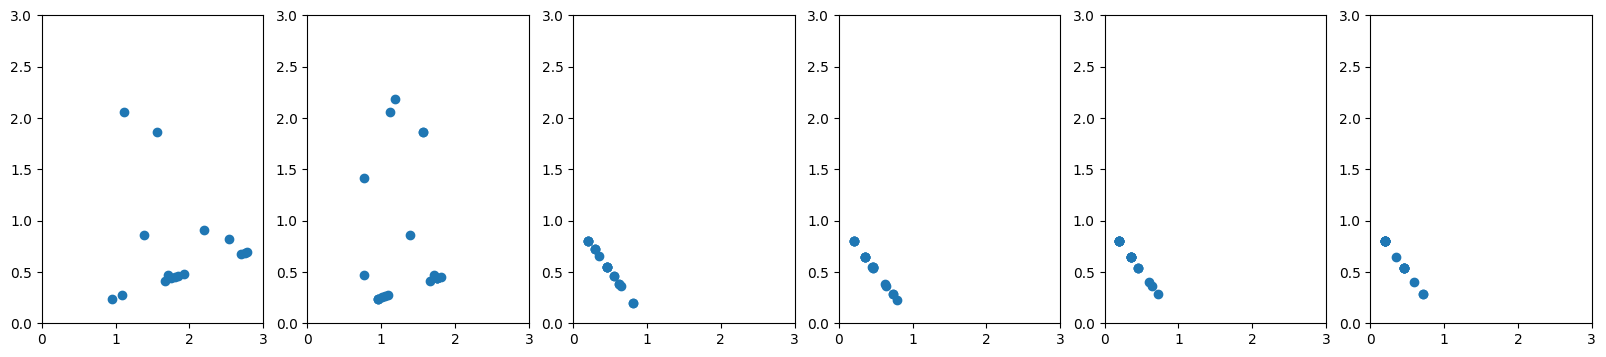

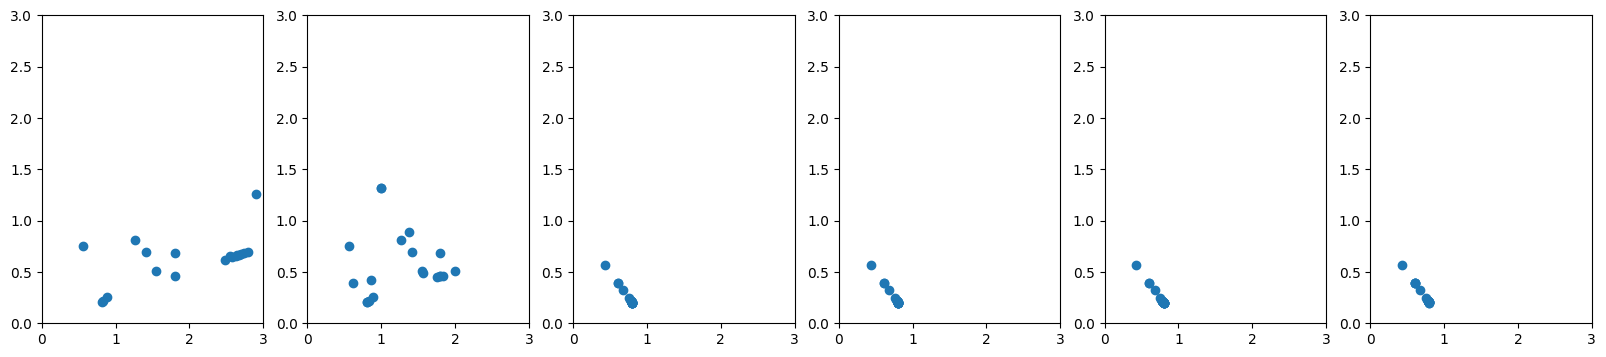

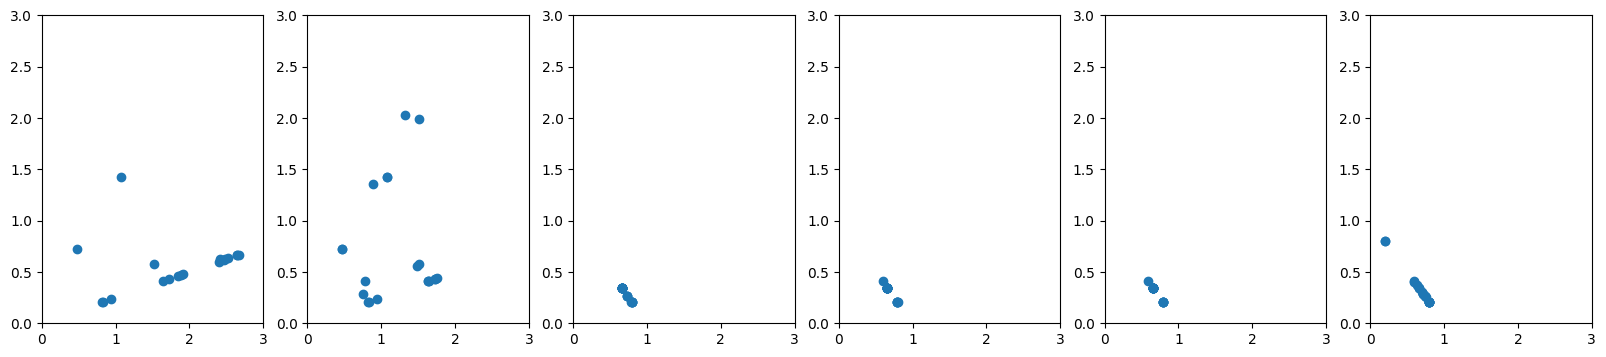

In [15]:
SEED=123
np.random.seed(SEED)
N_RUNS = 10

def run_experiment(useCD=False):
    runs_stats = []
    for i in range(N_RUNS):
        run_stats = []
        fig, ax = plt.subplots(1, 6, figsize=(20, 4))
        curr_ax = 0
        # Omitting CD
        N = 20  # population size
        GEN = 100  # generation number/ number of iterations

        P = constructInitialPopulation(N)
        applyScoresAndSort(P, useCD=useCD)
        plotPopul(P, ax[curr_ax])
        for gen in range(GEN):
            C = constructParents(N, P)
            O = constructOffspring(P, C, gen + 1, 0.1)
            M = P + O
            applyScoresAndSort(M, useCD=useCD)
            P = M[:N]  # get N best individuals
            if gen % (GEN / 4) == 0 or gen == GEN - 1:
                curr_ax += 1
                plotPopul(P, ax[curr_ax])  # step size for population illustration

            run_stats.append(getStatsCD(P))
        runs_stats.append(run_stats)
    
    return np.array(runs_stats).mean(axis=0)

withouth_stats = run_experiment(useCD=False)

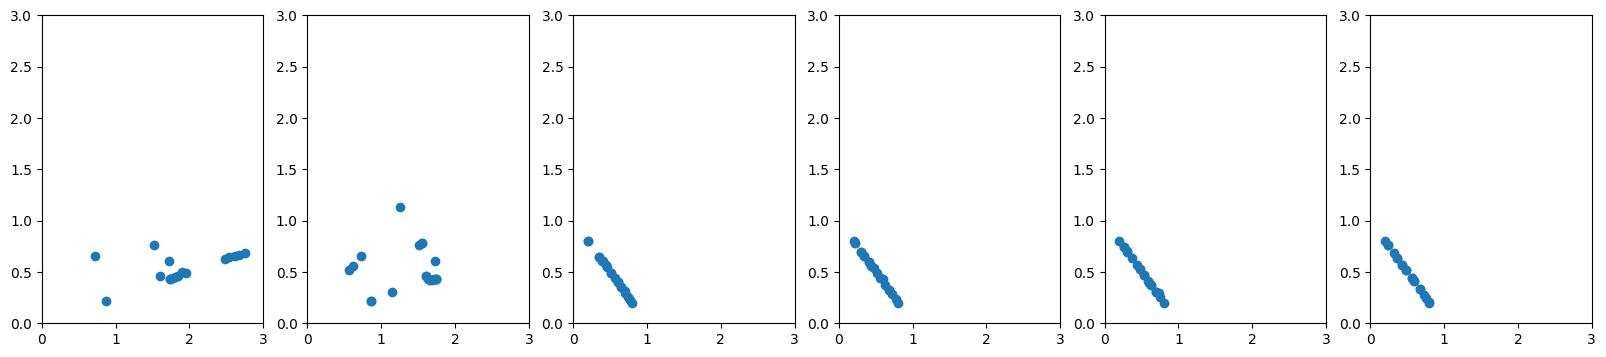

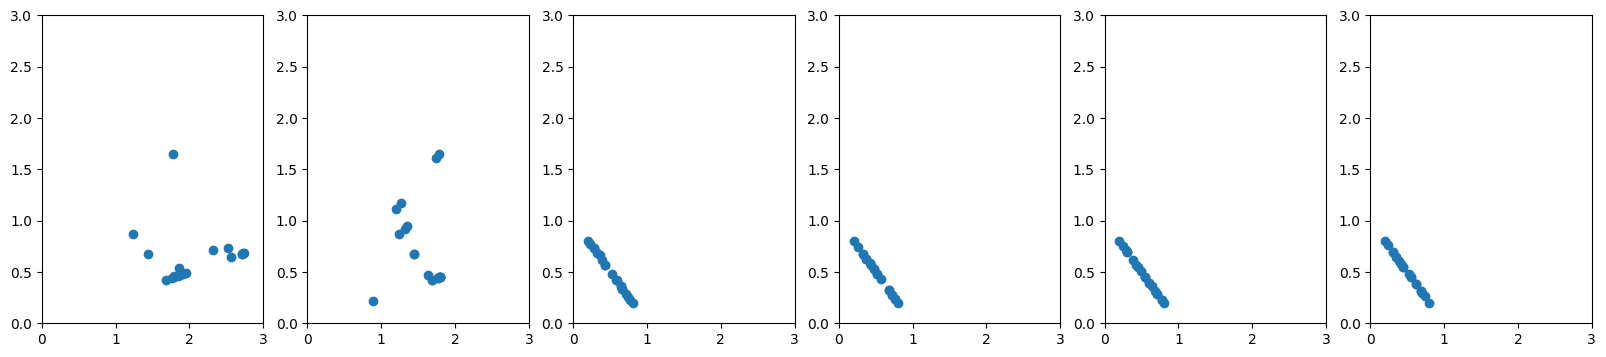

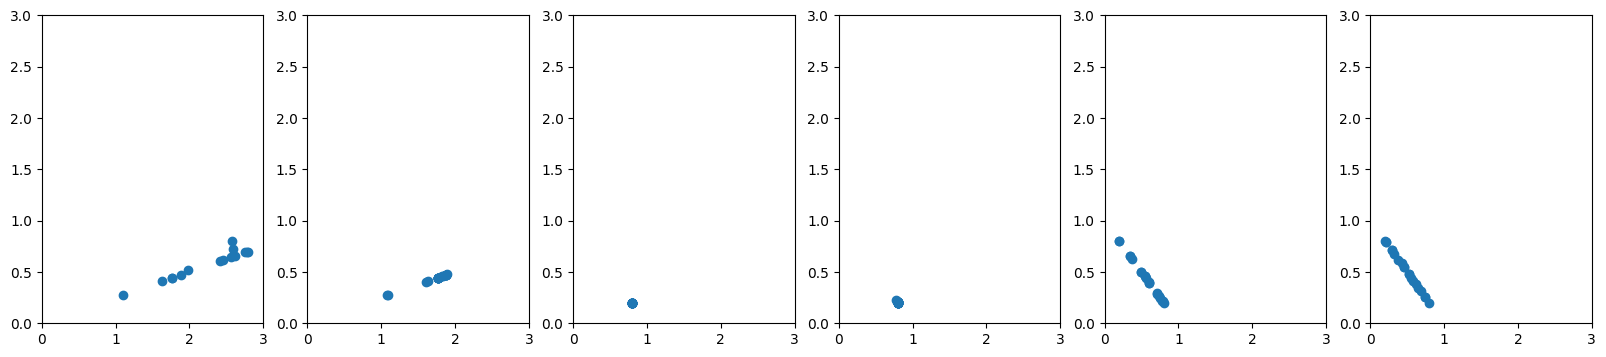

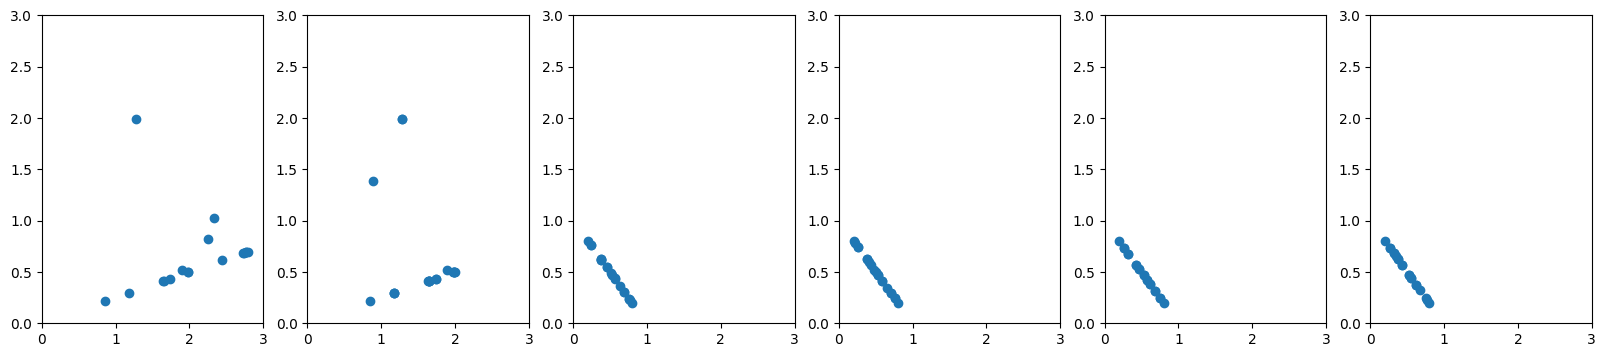

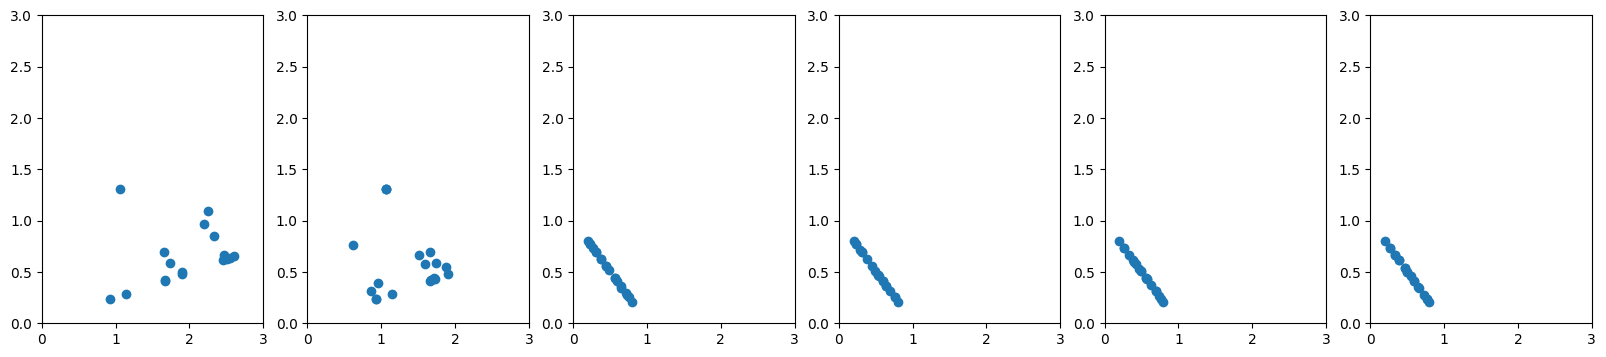

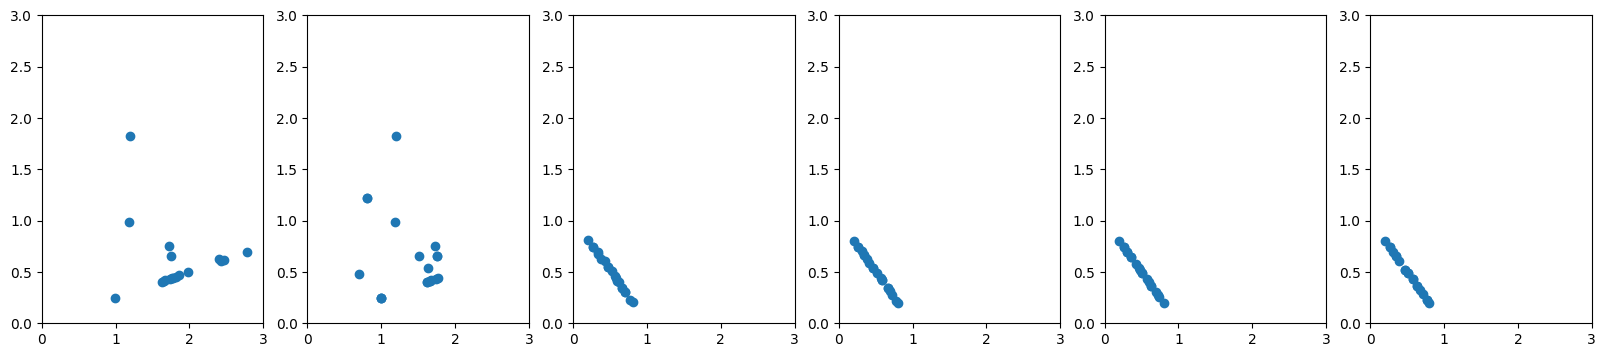

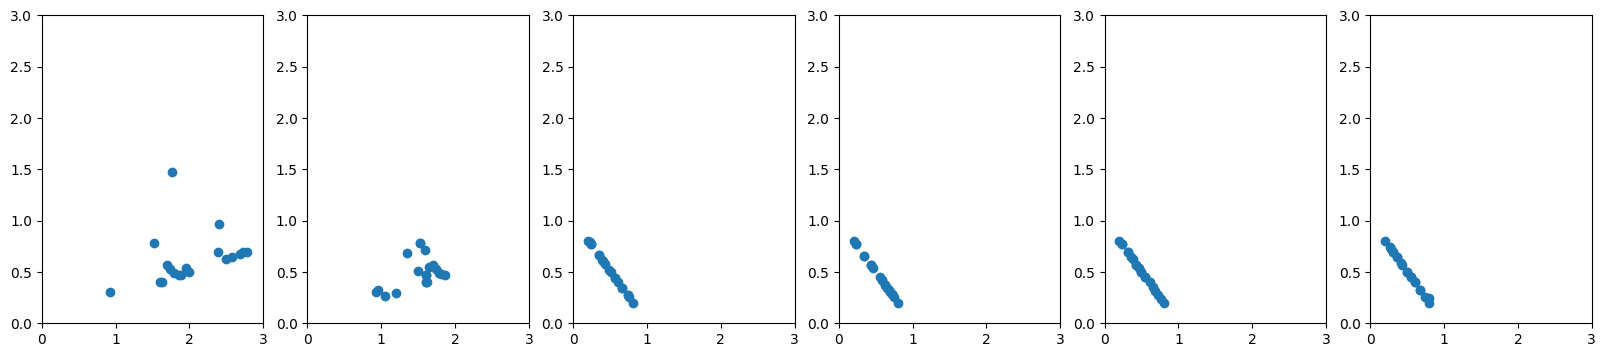

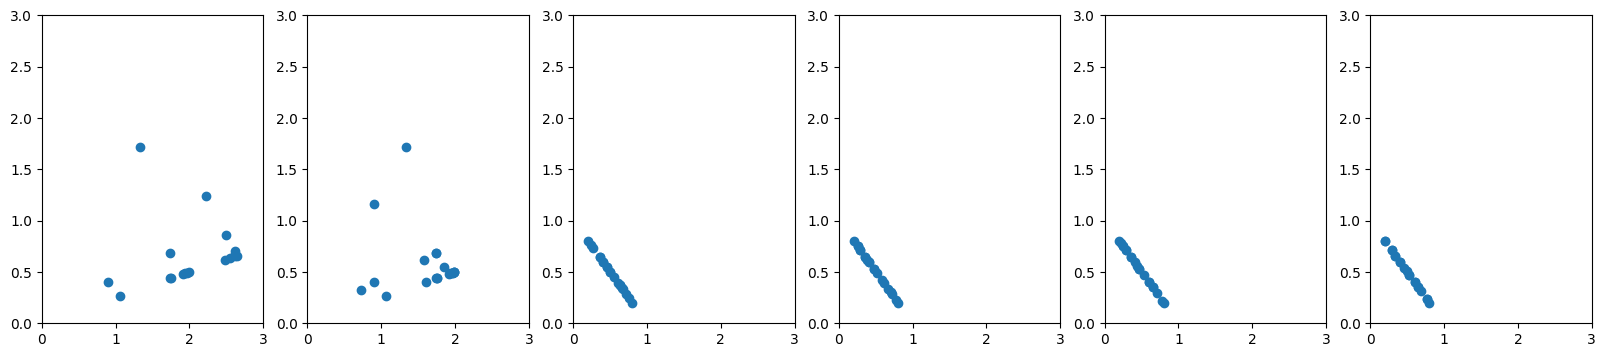

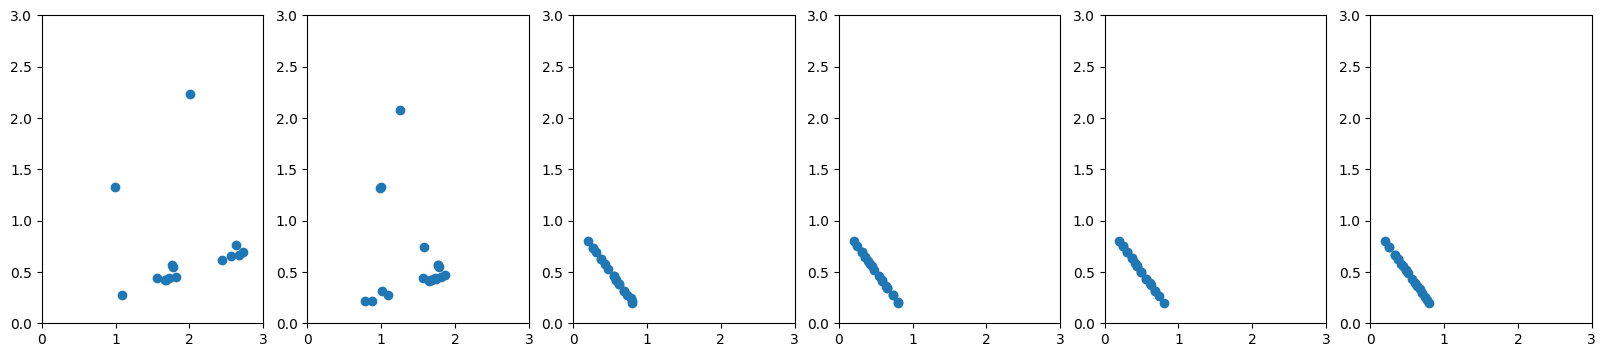

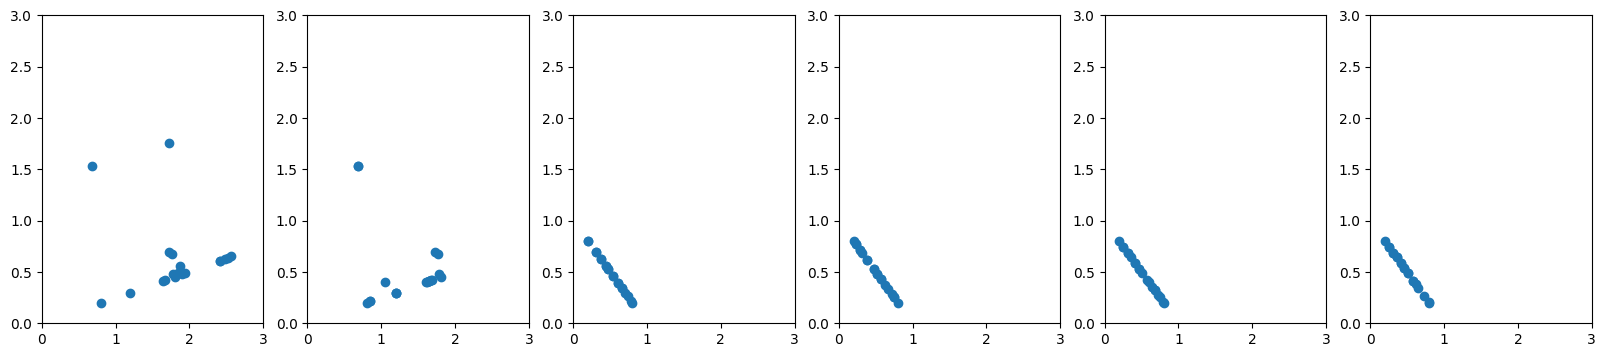

In [16]:
with_stats = run_experiment(useCD=True)

From here we can clearly see that solutions obtained with CD are much better we have better representation of the Pareto Front.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


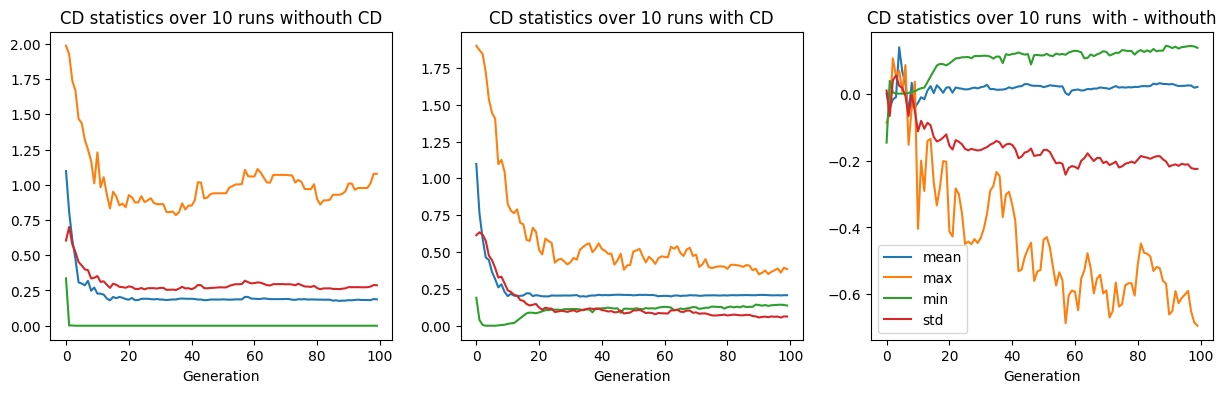

In [17]:
fig, ax = plt.subplots(1,3, figsize=(15, 4))
j = 0
for stats, useCD in zip([withouth_stats, with_stats, with_stats - withouth_stats], ["withouth CD" , "with CD", " with - withouth"]):
    for i, stat in enumerate(["mean", "max", "min", "std"]):
        ax[j].plot(stats[:, i], label=stat)
        ax[j].set_title(f"CD statistics over {N_RUNS} runs {useCD}")
        ax[j].set_xlabel("Generation")
    j+=1
    plt.legend()

Here situation may look a little bit counterintuitive at first but it makes perfect sense:
* `deviation` of the runs `withouth` CD is bigger as we obtained more condence pareto front most solutions are put in one place with some outliers which make the variance big.
* `min value` is bigger for the runs `with` CD as it clearly creates more uniform pareto front withouth CD the distance is almost 0
* `Mean` values are almost identical in both cases. However the variance explains differences.
* `Max` value proves our intution about many outliers which try to fool US that CD is big when we don't use it in selection

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


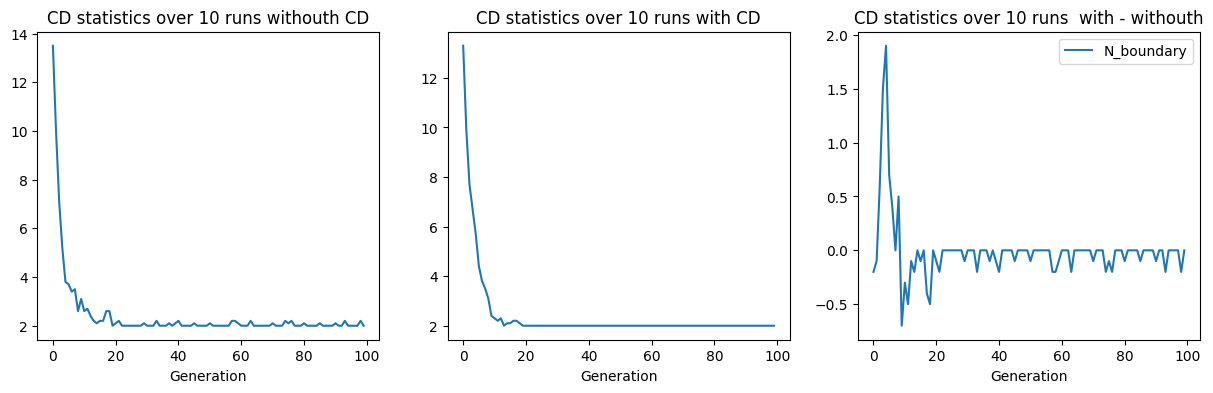

In [18]:
fig, ax = plt.subplots(1,3, figsize=(15, 4))
j = 0
for stats, useCD in zip([withouth_stats, with_stats, with_stats - withouth_stats], ["withouth CD" , "with CD", " with - withouth"]):
    ax[j].plot(stats[:, 4], label="N_boundary")
    ax[j].set_title(f"CD statistics over {N_RUNS} runs {useCD}")
    ax[j].set_xlabel("Generation")
    j+=1
    plt.legend()

Here we see what we wanted - the number of fronts and whats connected with it - number of boundary solutions seems to decrease as we move on.